##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with a CNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [6]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

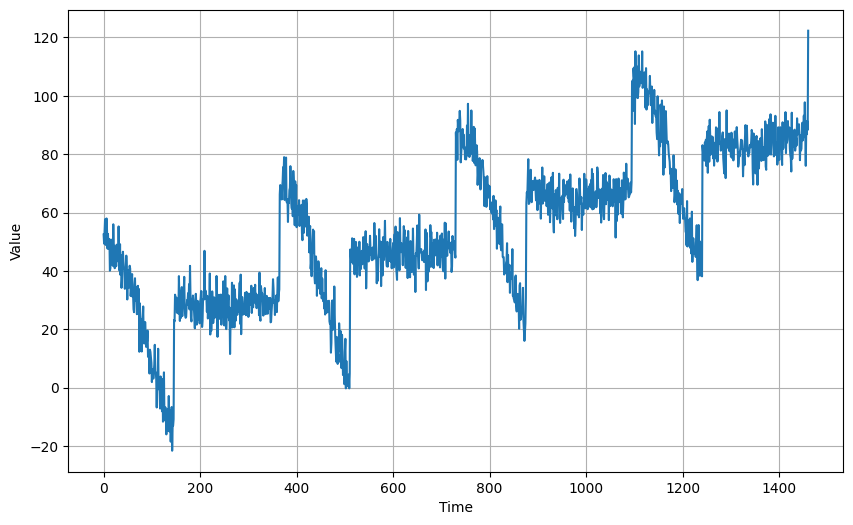

In [7]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [8]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 7s 28ms/step - loss: 34.5132 - mae: 35.0128 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 34.2593 - mae: 34.7589 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 33.8508 - mae: 34.3503 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 33.3447 - mae: 33.8443 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 32.7572 - mae: 33.2565 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 32.0955 - mae: 32.5945 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 31.3589 - mae: 31.8577 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 30.5437 - mae: 31.0422 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 29.6527 - mae: 30.1506 - lr: 2.5119e-08

(1e-08, 0.0001, 0.0, 30.0)

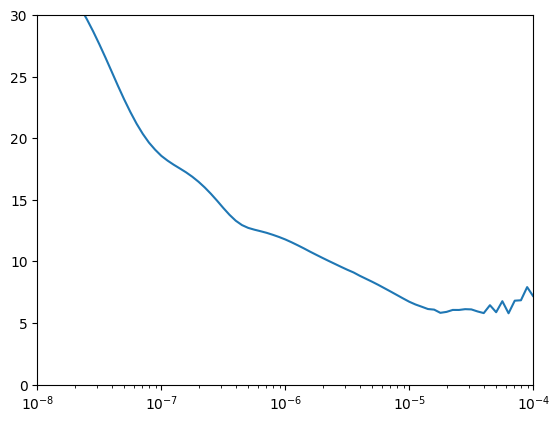

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 135ms/step - loss: 856.4420 - mae: 856.9419 - val_loss: 342.2681 - val_mae: 342.7681
Epoch 2/500
7/8 [=========================>....] - ETA: 0s - loss: 197.7778 - mae: 198.2778

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 23ms/step - loss: 205.7069 - mae: 206.2069 - val_loss: 315.9373 - val_mae: 316.4373
Epoch 3/500
8/8 [==============================] - 0s 33ms/step - loss: 205.6348 - mae: 206.1348 - val_loss: 310.3828 - val_mae: 310.8828
Epoch 4/500
8/8 [==============================] - 0s 23ms/step - loss: 205.0936 - mae: 205.5936 - val_loss: 307.9921 - val_mae: 308.4920
Epoch 5/500
8/8 [==============================] - 0s 33ms/step - loss: 205.4600 - mae: 205.9600 - val_loss: 306.9553 - val_mae: 307.4553
Epoch 6/500
8/8 [==============================] - 0s 22ms/step - loss: 205.0435 - mae: 205.5435 - val_loss: 306.5007 - val_mae: 307.0007
Epoch 7/500
8/8 [==============================] - 0s 22ms/step - loss: 205.3468 - mae: 205.8468 - val_loss: 306.2966 - val_mae: 306.7967
Epoch 8/500
8/8 [==============================] - 0s 21ms/step - loss: 204.6467 - mae: 205.1467 - val_loss: 306.2004 - val_mae: 306.7004
Epoch 9/500
8/8 [=============================

In [12]:
model = keras.models.load_model("my_checkpoint.h5")

In [13]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 7ms/step


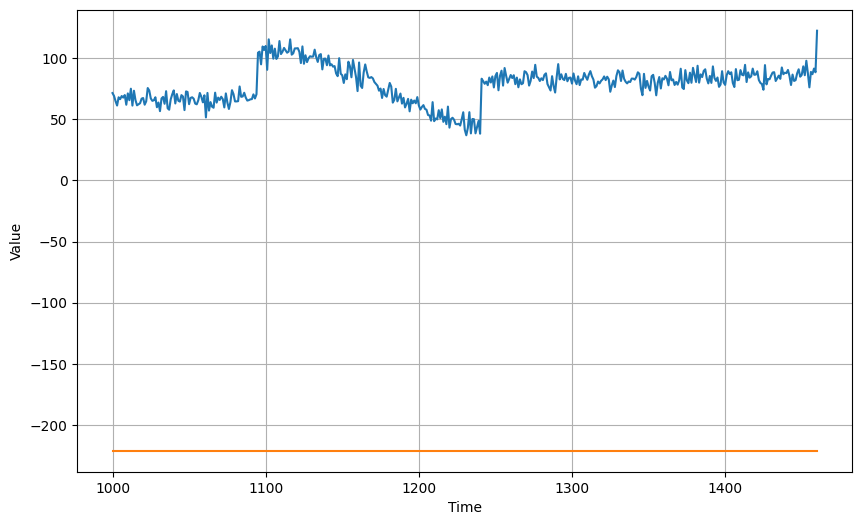

In [14]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [15]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

299.40604

## Fully Convolutional Forecasting

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 76ms/step - loss: 40.3398 - mae: 40.8388 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 7ms/step - loss: 39.8944 - mae: 40.3933 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 39.3351 - mae: 39.8340 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 7ms/step - loss: 38.6182 - mae: 39.1170 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 37.6697 - mae: 38.1684 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 36.3701 - mae: 36.8688 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 7ms/step - loss: 34.4935 - mae: 34.9918 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 31.7728 - mae: 32.2710 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 27.6042 - mae: 28.1022 - lr: 1.8478e-04


(0.0001, 0.1, 0.0, 30.0)

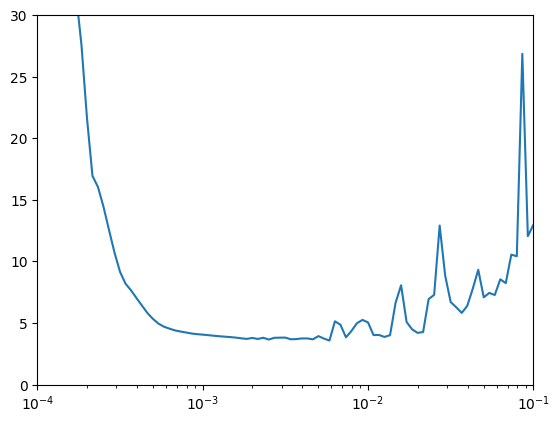

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [18]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 5s 131ms/step - loss: 41.3919 - mae: 41.8910 - val_loss: 74.8772 - val_mae: 75.3772
Epoch 2/500
8/8 [==============================] - 0s 33ms/step - loss: 38.4723 - mae: 38.9709 - val_loss: 65.1199 - val_mae: 65.6199
Epoch 3/500
8/8 [==============================] - 0s 33ms/step - loss: 30.0219 - mae: 30.5200 - val_loss: 33.3458 - val_mae: 33.8437
Epoch 4/500
8/8 [==============================] - 0s 24ms/step - loss: 17.4448 - mae: 17.9391 - val_loss: 27.0191 - val_mae: 27.5165
Epoch 5/500
8/8 [==============================] - 0s 34ms/step - loss: 14.2133 - mae: 14.7046 - val_loss: 21.8924 - val_mae: 22.3879
Epoch 6/500
8/8 [==============================] - 0s 34ms/step - loss: 11.1907 - mae: 11.6794 - val_loss: 13.6205 - val_mae: 14.1108
Epoch 7/500
8/8 [==============================] - 0s 35ms/step - loss: 8.4739 - mae: 8.9584 - val_loss: 9.8539 - val_mae: 10.3416
Epoch 8/500
8/8 [==============================] - 0s 34ms/step 

In [19]:
model = keras.models.load_model("my_checkpoint.h5")

In [20]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

44/44 [==============================] - 1s 11ms/step


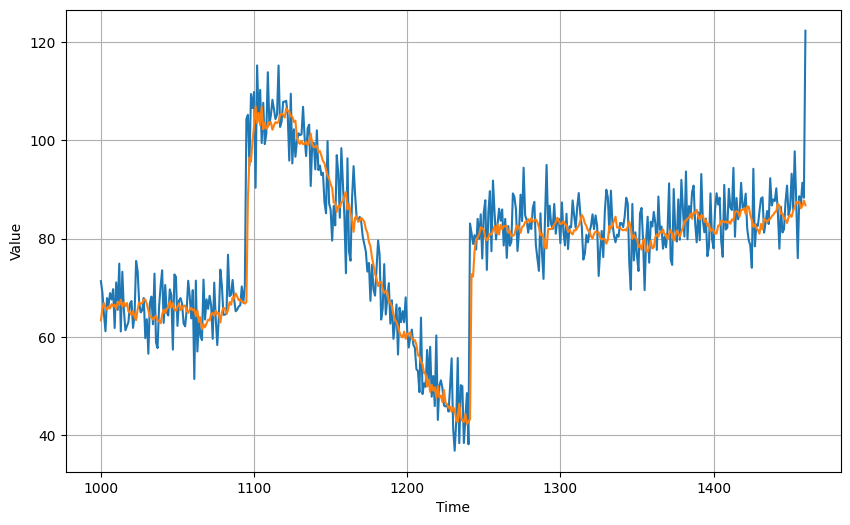

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [22]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.6051645